<a href="https://colab.research.google.com/github/voyager233/HUANG-Chenyi-Social-Media-Analysis-final-1M181024/blob/main/HUANG_Chenyi_1M181024_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# -*- coding: utf-8 -*-
!pip install fake-useragent
import requests,random,re
import time
import os
import csv
import sys
import json
import importlib
from fake_useragent import UserAgent
from lxml import etree

importlib.reload(sys)
startTime = time.time() 

#-------------------------------------------------------------------------------------------------
path = os.getcwd() + "/weiboComments.csv"
csvfile = open(path, 'a', newline='', encoding = 'utf-8-sig')
writer = csv.writer(csvfile)

writer.writerow(('titleURL','title_contents','user_ID', 'user_name', 'user_gender','created_data',
                 'created_time', 'repost','comment','thumbup', 'commentor_ID', 'commentor_name',
                 'commentor_gender', 'comment_date', 'comment_time','comment_content')) 

#
headers = {
    'Cookie': '_T_WM=22822641575; H5_wentry=H5; backURL=https%3A%2F%2Fm.weibo.cn%2F; ALF=1584226439; MLOGIN=1; SUBP=0033WrSXqPxfM725Ws9jqgMF55529P9D9W5RJaVYrb.BEuOvUQ8Ca2OO5JpX5K-hUgL.FoqESh-7eKzpShM2dJLoIp7LxKML1KBLBKnLxKqL1hnLBoMceoBfeh2EeKBN; SCF=AnRSOFp6QbWzfH1BqL4HB8my8eWNC5C33KhDq4Ko43RUIzs6rjJC49kIvz5_RcOJV2pVAQKvK2UbAd1Uh6j0pyo.; SUB=_2A25zQaQBDeRhGeBM71cR8SzNzzuIHXVQzcxJrDV6PUJbktAKLXD-kW1NRPYJXhsrLRnku_WvhsXi81eY0FM2oTtt; SUHB=0mxU9Kb_Ce6s6S; SSOLoginState=1581634641; WEIBOCN_FROM=1110106030; XSRF-TOKEN=dc7c27; M_WEIBOCN_PARAMS=oid%3D4471980021481431%26luicode%3D20000061%26lfid%3D4471980021481431%26uicode%3D20000061%26fid%3D4471980021481431',
    'Referer': 'https://m.weibo.cn/detail/4312409864846621',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.100 Safari/537.36',
    'X-Requested-With': 'XMLHttpRequest'
}

#-----------------------------------scrape ID in titles------------------------------------------
comments_ID = []
def get_title_id():
    for page in range(1,21):  #around 18 titles per page
        headers = {
            "User-Agent" : UserAgent().chrome 
        }
        time.sleep(1)
        
        api_url = 'https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=' + str(page)
        print(api_url)
        rep = requests.get(url=api_url, headers=headers)
        
        for json in rep.json()['data']['statuses']:
            comment_ID = json['id'] 
            comments_ID.append(comment_ID)

#-----------------------------------------------------------------------------         
def spider_title(comment_ID):
    try:
        article_url = 'https://m.weibo.cn/detail/'+ comment_ID
        print ("article_url = ", article_url)
        html_text = requests.get(url=article_url, headers=headers).text
        
        find_title = re.findall('.*?"text": "(.*?)",.*?', html_text)[0]
        title_text = re.sub('<(S*?)[^>]*>.*?|<.*? />', '', find_title) #正则匹配掉html标签
        print ("title_text = ", title_text)
       
        title_user_id = re.findall('.*?"id": (.*?),.*?', html_text)[1]
        print ("title_user_id = ", title_user_id)
        
        title_user_NicName = re.findall('.*?"screen_name": "(.*?)",.*?', html_text)[0]
        print ("title_user_NicName = ", title_user_NicName)
        
        title_user_gender = re.findall('.*?"gender": "(.*?)",.*?', html_text)[0]
        print ("title_user_gender = ", title_user_gender)
       
        created_title_time = re.findall('.*?"created_at": "(.*?)".*?', html_text)[0].split(' ')
        #time
        if 'Mar' in created_title_time:
            title_created_YMD = "{}/{}/{}".format(created_title_time[-1], '03', created_title_time[2])
        elif 'Feb' in created_title_time:
            title_created_YMD = "{}/{}/{}".format(created_title_time[-1], '02', created_title_time[2])
        elif 'Jan' in created_title_time:
            title_created_YMD = "{}/{}/{}".format(created_title_time[-1], '01', created_title_time[2])
        else:
            print ('not in the period！URL = ')
            pass
        print ("title_created_YMD = ", title_created_YMD)
        #add_title_time
        add_title_time = created_title_time[3]
        print ("add_title_time = ", add_title_time)
        #reposts_count
        reposts_count = re.findall('.*?"reposts_count": (.*?),.*?', html_text)[0]
        print ("reposts_count = ", reposts_count)
        #comments_count
        comments_count = re.findall('.*?"comments_count": (.*?),.*?', html_text)[0]
        print ("comments_count = ", comments_count)
        #attitudes_count
        attitudes_count = re.findall('.*?"attitudes_count": (.*?),.*?', html_text)[0]
        print ("attitudes_count = ", attitudes_count)   
        comment_count = int(int(comments_count) / 20) #20 lines per ajax
        position1 = (article_url, title_text, title_user_id, title_user_NicName,title_user_gender, title_created_YMD, add_title_time, reposts_count, comments_count, attitudes_count, " ", " ", " ", " "," ", " ")
        
        writer.writerow((position1))
        return comment_count
    except:
        pass


#----------------------------------------------------------------------------------------------------
#comment_ID
def get_page(comment_ID, max_id, id_type):
    params = {
        'max_id': max_id,
        'max_id_type': id_type
    }
    url = ' https://m.weibo.cn/comments/hotflow?id={}&mid={}&max_id'.format(comment_ID, comment_ID)
    try:
        r = requests.get(url, params=params, headers=headers)
        if r.status_code == 200:
            return r.json()
    except requests.ConnectionError as e:
        print('error', e.args)
        pass

#----------------------------------------------------------------------------------------------------
def parse_page(jsondata):
    if jsondata:
        items = jsondata.get('data')
        item_max_id = {}
        item_max_id['max_id'] = items['max_id']
        item_max_id['max_id_type'] = items['max_id_type']
        return item_max_id

#----------------------------------------------------------------------------------------------------
def write_csv(jsondata):
    for json in jsondata['data']['data']:
        #user_id
        user_id = json['user']['id']
        # user_name
        user_name = json['user']['screen_name']
        # user_gender
        user_gender = json['user']['gender']
        #comment
        comments_text = json['text']
        comment_text = re.sub('<(S*?)[^>]*>.*?|<.*? />', '', comments_text) #html label
        # created_times
        created_times = json['created_at'].split(' ')
        if 'Feb' in created_times:
            created_YMD = "{}/{}/{}".format(created_times[-1], '02', created_times[2])
        elif 'Jan' in created_times:
            created_YMD = "{}/{}/{}".format(created_times[-1], '01', created_times[2])
        else:
            print ('not in the period')
            pass
        created_time = created_times[3] #second
        #if len(comment_text) != 0:
        position2 = (" ", " ", " ", " "," ", " ", " ", " ", " ", " ", user_id, user_name, user_gender, created_YMD, created_time, comment_text)
        writer.writerow((position2))
        #print (user_id, user_name, user_gender, created_YMD, created_time)    


#----------------------------------------------------------------------------------------------------
def main():
    count_title = len(comments_ID)
    for count, comment_ID in enumerate(comments_ID):
        print ("scraping NO%s title，%stitles in total"%(count+1, count_title))
        
        maxPage = spider_title(comment_ID)
        print ('maxPage = ', maxPage)
        m_id = 0
        id_type = 0
        if maxPage != 0: 
            try:
                
                for page in range(0, maxPage):
                    
                    jsondata = get_page(comment_ID, m_id, id_type)
                    
                    
                    write_csv(jsondata)
                    
                    
                    results = parse_page(jsondata)
                    time.sleep(1)
                    m_id = results['max_id']
                    id_type = results['max_id_type']              
            except:
                pass
        print ("-----------------------------------------------------")
    csvfile.close() 
    
if __name__ == '__main__':
    
    #get title ID
    get_title_id()
    
    
    main()
    
    
    endTime = time.time()
    useTime = (endTime-startTime) / 60
    print("used%sminutes"%useTime)


#data scraping part reference:https://blog.csdn.net/ayouleyang/article/details/104306270

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=b0df8e47e777ace320ee9d38d4e5a040b4d33bec0b1f85a00483a67a30b3aeb9
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
Successfully built fake-useragent


Error occurred during loading data. Trying to use cache server https://fake-useragent.herokuapp.com/browsers/0.1.11
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 154, in load
    for item in get_browsers(verify_ssl=verify_ssl):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 99, in get_browsers
    html = html.split('<table class="w3-table-all notranslate">')[1]
IndexError: list index out of range


https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=1
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=2
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=3
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=4
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=5
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=6
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=7
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=8
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=9
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=10
https://m.weibo.cn/api/feed/trendtop?containerid=102803_ctg1_600059_-_ctg1_600059&page=11
https://m.weibo.cn/

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.171 seconds.
Prefix dict has been built successfully.


['【', '转扩', '！', '#', '急寻', '珠海', '境外', '输入', '病例', '密切接触', '者', '#', '】', '3', '月', '20', '日', '，', '广东省', '卫生', '健康', '委', '公布', '，', '珠海市', '新增', '1', '例', '境外', '输入', '新冠', '肺炎', '确诊', '病例', '。', '第', '1', '例', '境外', '（', '英国', '）', '输入', '病例', '，', '男', '，', '54', '岁', '，', '几内亚共和国', '籍', '，', '独自一人', '在', '广州', '经商', '约', '15', '年', '，', '家人', '在', '英国伦敦', '居住', '，', '1', '月', '15', '日至', '3', '月', '16', '日', '期间', '回', '伦敦', '探亲', '。', '该', '病例', '于', '3', '月', '19', '日', '中午', '确诊', '，', '确诊', '前', '主要', '的', '活动', '轨迹', '（', '以下', '时间', '均', '为', '北京', '时间', '）', '：', '3', '月', '16', '日', '4', ':', '20', '，', '从', '英国伦敦', '希斯罗', '机场', 'T3', '乘坐', '阿联酋', '航空', 'EK004', '到达', '迪拜', '（', '座位号', '59G', '）', '。', '3', '月', '16', '日', '11', ':', '20', '，', '到', '迪拜', '机场', 'T3', '。', '3', '月', '16', '日', '13', ':', '55', '，', '从', '迪拜', '机场', 'T3', '乘坐', '阿联酋', '航空', 'EK0380', '飞', '香港', '（', '座位号', '50B', '）', '。', '3', '月', '16', '日', '21', ':', '05', '，', '到达', '香港机场', 'T1', '，',

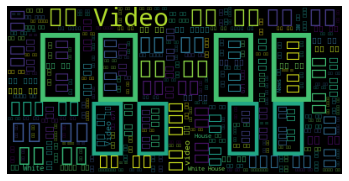

In [6]:
# coding=utf-8
import jieba
import re
import sys
import time
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud


cut_words = ""
all_words = ""
f = open('data-fenci.txt', 'w')
for line in open('data.txt', encoding='utf-8'):
    line.strip('\n')
    seg_list = jieba.cut(line,cut_all=False)
    # print(" ".join(seg_list))
    cut_words = (" ".join(seg_list))
    f.write(cut_words)
    all_words += cut_words
else:
    f.close()


all_words = all_words.split()
print(all_words)

# frequency
c = Counter()
for x in all_words:
    if len(x)>1 and x != '\r\n':
        c[x] += 1

# top 10
print('\nword frequency result：')
for (k,v) in c.most_common(10):
    print("%s:%d"%(k,v))


name = time.strftime("%Y-%m-%d") + "-fc.csv"
fw = open(name, 'w', encoding='utf-8')
i = 1
for (k,v) in c.most_common(len(c)):
    fw.write(str(i)+','+str(k)+','+str(v)+'\n')
    i = i + 1
else:
    print("Over write file!")
    fw.close()

#wordcloud

text = open('data.txt').read()
 

wordlist = jieba.cut(text, cut_all = False)
 

wl_space_split = " ".join(wordlist)
#print(wl_space_split)
 

my_wordcloud = WordCloud().generate(wl_space_split)
 

plt.imshow(my_wordcloud)

plt.axis("off")
plt.show()

In [ ]:
#another wordcloud
# coding=utf-8
import jieba
import re
import time
from collections import Counter

#-----------------------------------------------------------------------
cut_words = ""
all_words = ""
f = open('C-class-fenci.txt', 'w')
for line in open('C-class.txt', encoding='utf-8'):
    line.strip('\n')
    seg_list = jieba.cut(line,cut_all=False)
    # print(" ".join(seg_list))
    cut_words = (" ".join(seg_list))
    f.write(cut_words)
    all_words += cut_words
else:
    f.close()


all_words = all_words.split()
print(all_words)


c = Counter()
for x in all_words:
    if len(x)>1 and x != '\r\n':
        c[x] += 1

# top 10
print('\nwordfrequency：')
for (k,v) in c.most_common(10):
    print("%s:%d"%(k,v))


name = time.strftime("%Y-%m-%d") + "-fc.csv"
fw = open(name, 'w', encoding='utf-8')
i = 1
for (k,v) in c.most_common(len(c)):
    fw.write(str(i)+','+str(k)+','+str(v)+'\n')
    i = i + 1
else:
    print("Over write file!")
    fw.close()

#-----------------------------------------------------------------------
from pyecharts import options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType


words = []
for (k,v) in c.most_common(1000):
    # print(k, v)
    words.append((k,v))


def wordcloud_base() -> WordCloud:
    c = (
        WordCloud()
        .add("", words, word_size_range=[20, 100], shape=SymbolType.ROUND_RECT)
        .set_global_opts(title_opts=opts.TitleOpts(title='wordcloud'))
    )
    return c


wordcloud_base().render('wordcloud.html')


     |████████████████████████████████| 37.6 MB 1.2 MB/s 
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760963 sha256=2992b09a8e8a87070b4362f9037bd9e49f3c13ecee0584b12a3508b4ab328561
  Stored in directory: /root/.cache/pip/wheels/4a/7a/fe/a5747434679b22a95c93bcf9fa49a988f5d9be56366bdf6c79
Successfully built snownlp
4.440892098500626e-16
0.49055395607520824
0.9999999999972635
0.9999998677093149
0.9979627586368516
0.9999999990959509
0.9999830199233769
0.9998699310812647
0.9999954477924106
0.9999999999999989
0.9998423657837353
0.9977423477969629
0.8419238349496181
0.9999865484734526
0.9999999999393359
0.999999778777973
0.999999999682351
0.5997754895392834
4.440892098500626e-16
0.997595004364657
0.0825662172567001
0.052922109929199324
0.9979627586368516
0.9999999990959509
0.9116902785034688
0.9977423477969629
0.9999865484734526
0.9999954477924106
0.9998423657837353
0.9999999999999989
1.349371725467563e-09
0.9998699310812647
0.9999999999393359
0.99998301992337

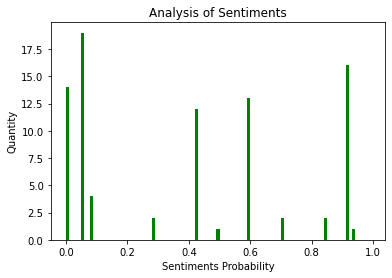

In [8]:
# -*- coding: utf-8 -*-
!pip install snownlp
from snownlp import SnowNLP
import codecs
import os

source = open("data.txt","r", encoding='utf-8')
line = source.readlines()
sentimentslist = []
for i in line:
    s = SnowNLP(i)
    print(s.sentiments)
    sentimentslist.append(s.sentiments)

import matplotlib.pyplot as plt
import numpy as np
plt.hist(sentimentslist, bins = np.arange(0, 1, 0.01), facecolor = 'g')
plt.xlabel('Sentiments Probability')
plt.ylabel('Quantity')
plt.title('Analysis of Sentiments')
plt.show()

4.440892098500626e-16
0.49055395607520824
0.9999999999972635
0.9999998677093149
0.9979627586368516
0.9999999990959509
0.9999830199233769
0.9998699310812647
0.9999954477924106
0.9999999999999989
0.9998423657837353
0.9977423477969629
0.8419238349496181
0.9999865484734526
0.9999999999393359
0.999999778777973
0.999999999682351
0.5997754895392834
4.440892098500626e-16
0.997595004364657
0.0825662172567001
0.052922109929199324
0.9979627586368516
0.9999999990959509
0.9116902785034688
0.9977423477969629
0.9999865484734526
0.9999954477924106
0.9998423657837353
0.9999999999999989
1.349371725467563e-09
0.9998699310812647
0.9999999999393359
0.9999830199233769
0.999999999682351
0.5997754895392834
0.9999905557871165
0.429235317066477
0.9948923461359481
0.9999998677093149
0.9979627586368516
0.9998423657837353
0.9999999990959509
0.9999999999999989
1.349371725467563e-09
0.9999954477924106
0.9116902785034688
0.9999865484734526
0.9977423477969629
0.9999999999393359
0.05451755438692951
0.9999830199233769
0

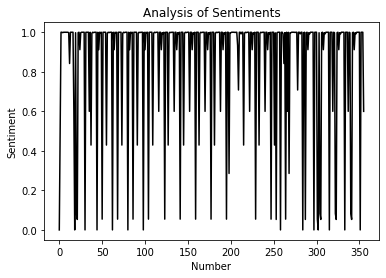

In [9]:

# -*- coding: utf-8 -*-
from snownlp import SnowNLP
import codecs
import os

source = open("data.txt","r", encoding='utf-8')
line = source.readlines()
sentimentslist = []
for i in line:
    s = SnowNLP(i)
    print(s.sentiments)
    sentimentslist.append(s.sentiments)

import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(0, 356, 1), sentimentslist, 'k-')
plt.xlabel('Number')
plt.ylabel('Sentiment')
plt.title('Analysis of Sentiments')
plt.show()

4.440892098500626e-16
0.49055395607520824
0.9999999999972635
0.9999998677093149
0.9979627586368516
0.9999999990959509
0.9999830199233769
0.9998699310812647
0.9999954477924106
0.9999999999999989
0.9998423657837353
0.9977423477969629
0.8419238349496181
0.9999865484734526
0.9999999999393359
0.999999778777973
0.999999999682351
0.5997754895392834
4.440892098500626e-16
0.997595004364657
0.0825662172567001
0.052922109929199324
0.9979627586368516
0.9999999990959509
0.9116902785034688
0.9977423477969629
0.9999865484734526
0.9999954477924106
0.9998423657837353
0.9999999999999989
1.349371725467563e-09
0.9998699310812647
0.9999999999393359
0.9999830199233769
0.999999999682351
0.5997754895392834
0.9999905557871165
0.429235317066477
0.9948923461359481
0.9999998677093149
0.9979627586368516
0.9998423657837353
0.9999999990959509
0.9999999999999989
1.349371725467563e-09
0.9999954477924106
0.9116902785034688
0.9999865484734526
0.9977423477969629
0.9999999999393359
0.05451755438692951
0.9999830199233769
0

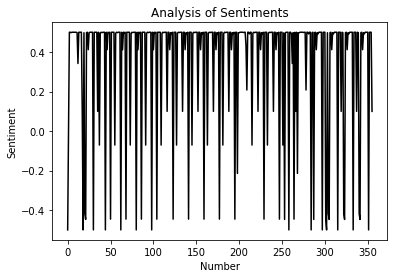

In [10]:
# -*- coding: utf-8 -*-
from snownlp import SnowNLP
import codecs
import os

#obtain score
source = open("data.txt","r", encoding='utf-8')
line = source.readlines()
sentimentslist = []
for i in line:
    s = SnowNLP(i)
    print(s.sentiments)
    sentimentslist.append(s.sentiments)

#convert to[-0.5, 0.5]
result = []
i = 0
while i<len(sentimentslist):
    result.append(sentimentslist[i]-0.5)
    i = i + 1

#visualization
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(0, 356, 1), result, 'k-')
plt.xlabel('Number')
plt.ylabel('Sentiment')
plt.title('Analysis of Sentiments')
plt.show()